Data shape: (1050, 5)


,window,target,Return,Risk,Residual
0,0,0.000,-0.000462,0.021210,0.000355
1,0,0.005,0.006942,0.031881,0.000006
2,0,0.010,0.014297,0.041298,0.000009
3,0,0.015,0.021979,0.052177,0.000026
4,0,0.020,0.028944,0.060094,0.000012


,window,target,Return,Risk,Residual
count,1050.000000,1050.000000,1050.000000,1050.000000,1.050000e+03
mean,24.500000,0.050000,0.004104,0.207237,1.491470e-03
std,14.437746,0.030291,0.063373,0.174919,3.604353e-02
min,0.000000,0.000000,-0.299465,0.013893,7.534920e-07
25%,12.000000,0.025000,-0.018595,0.084051,9.714930e-06
50%,24.500000,0.050000,0.005936,0.172738,2.544570e-05
75%,37.000000,0.075000,0.029547,0.277863,1.043952e-04
max,49.000000,0.100000,0.198511,1.336410,1.160040e+00


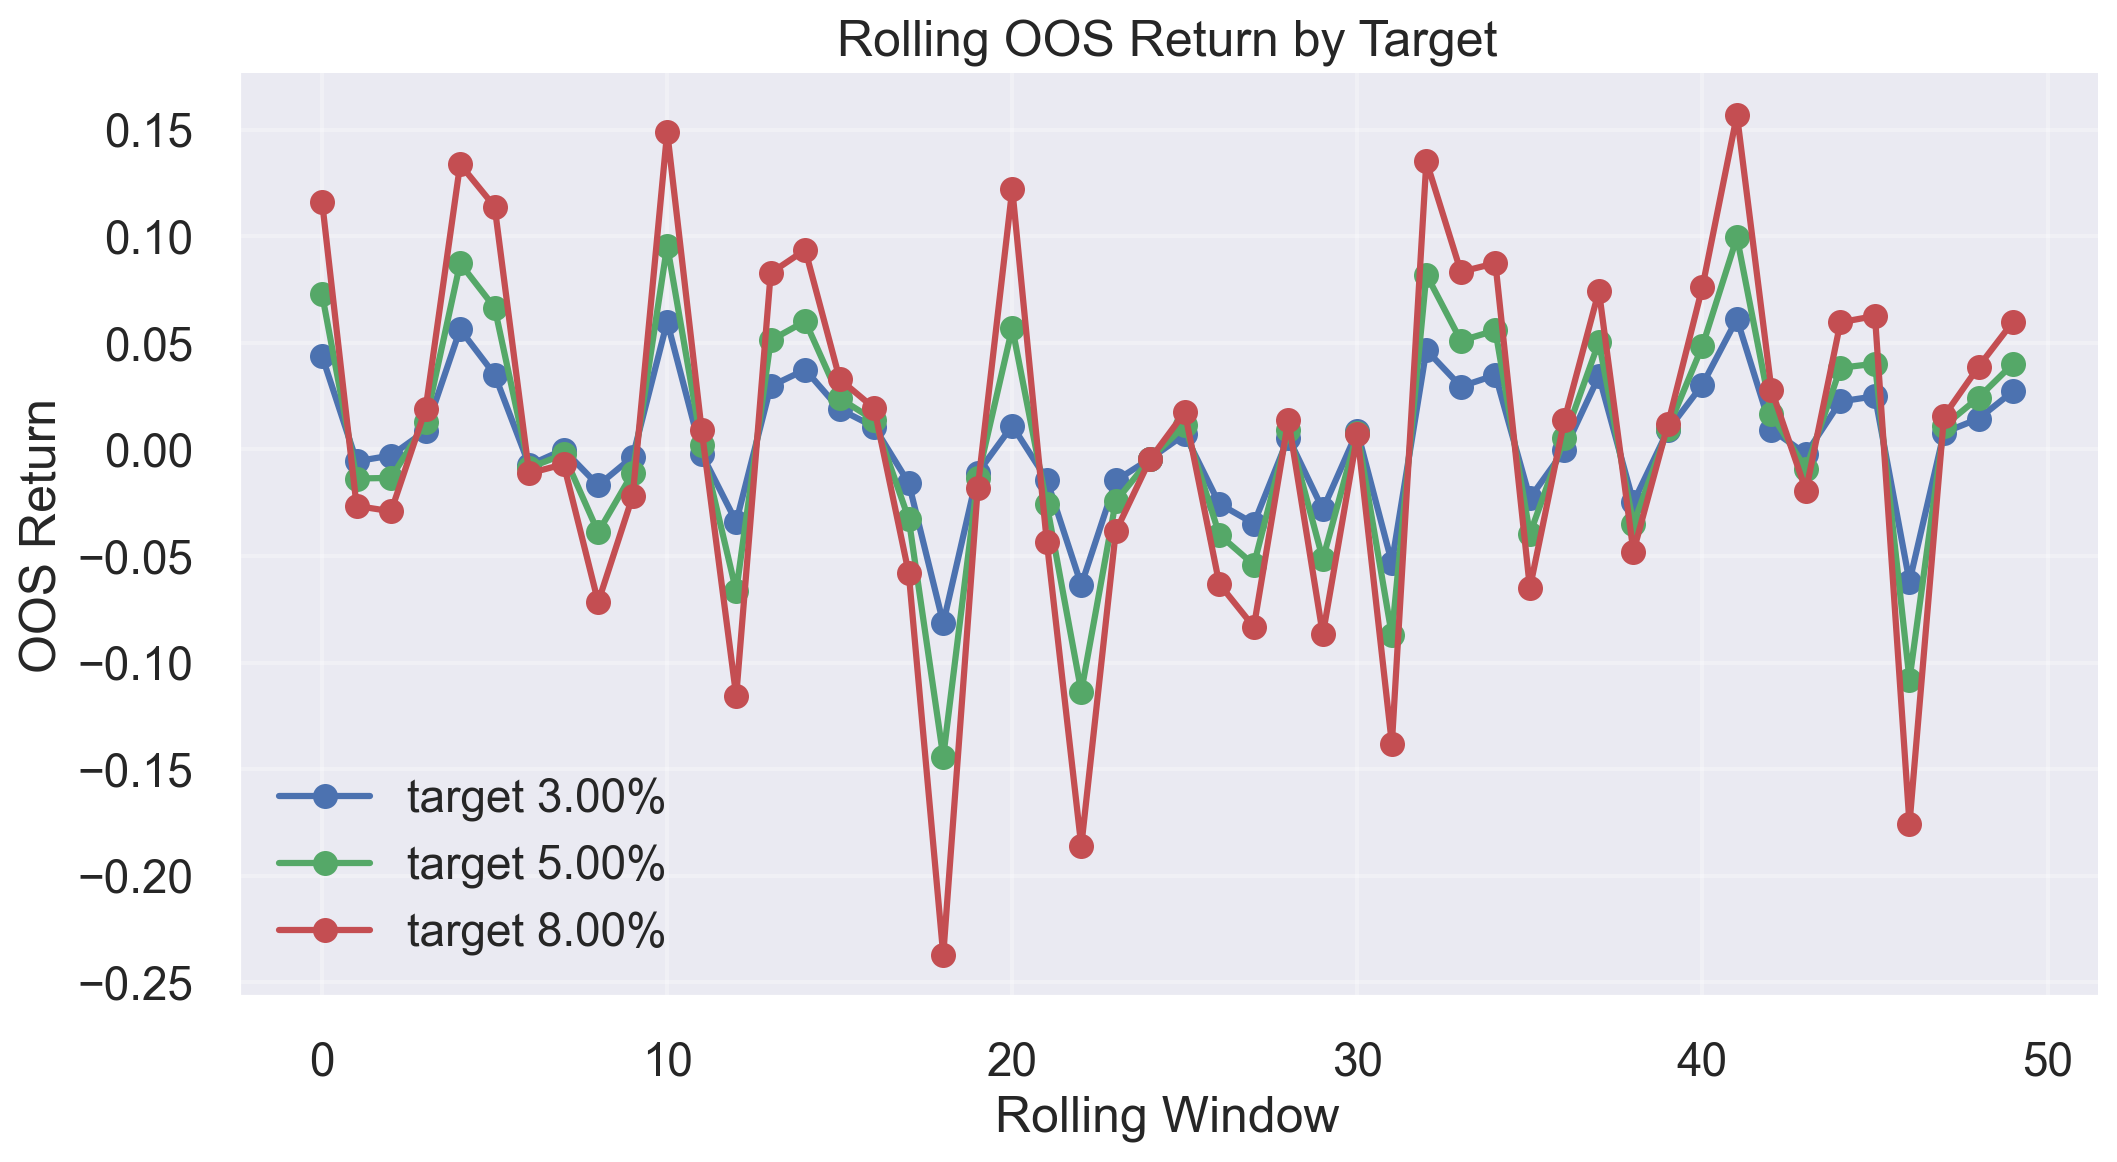

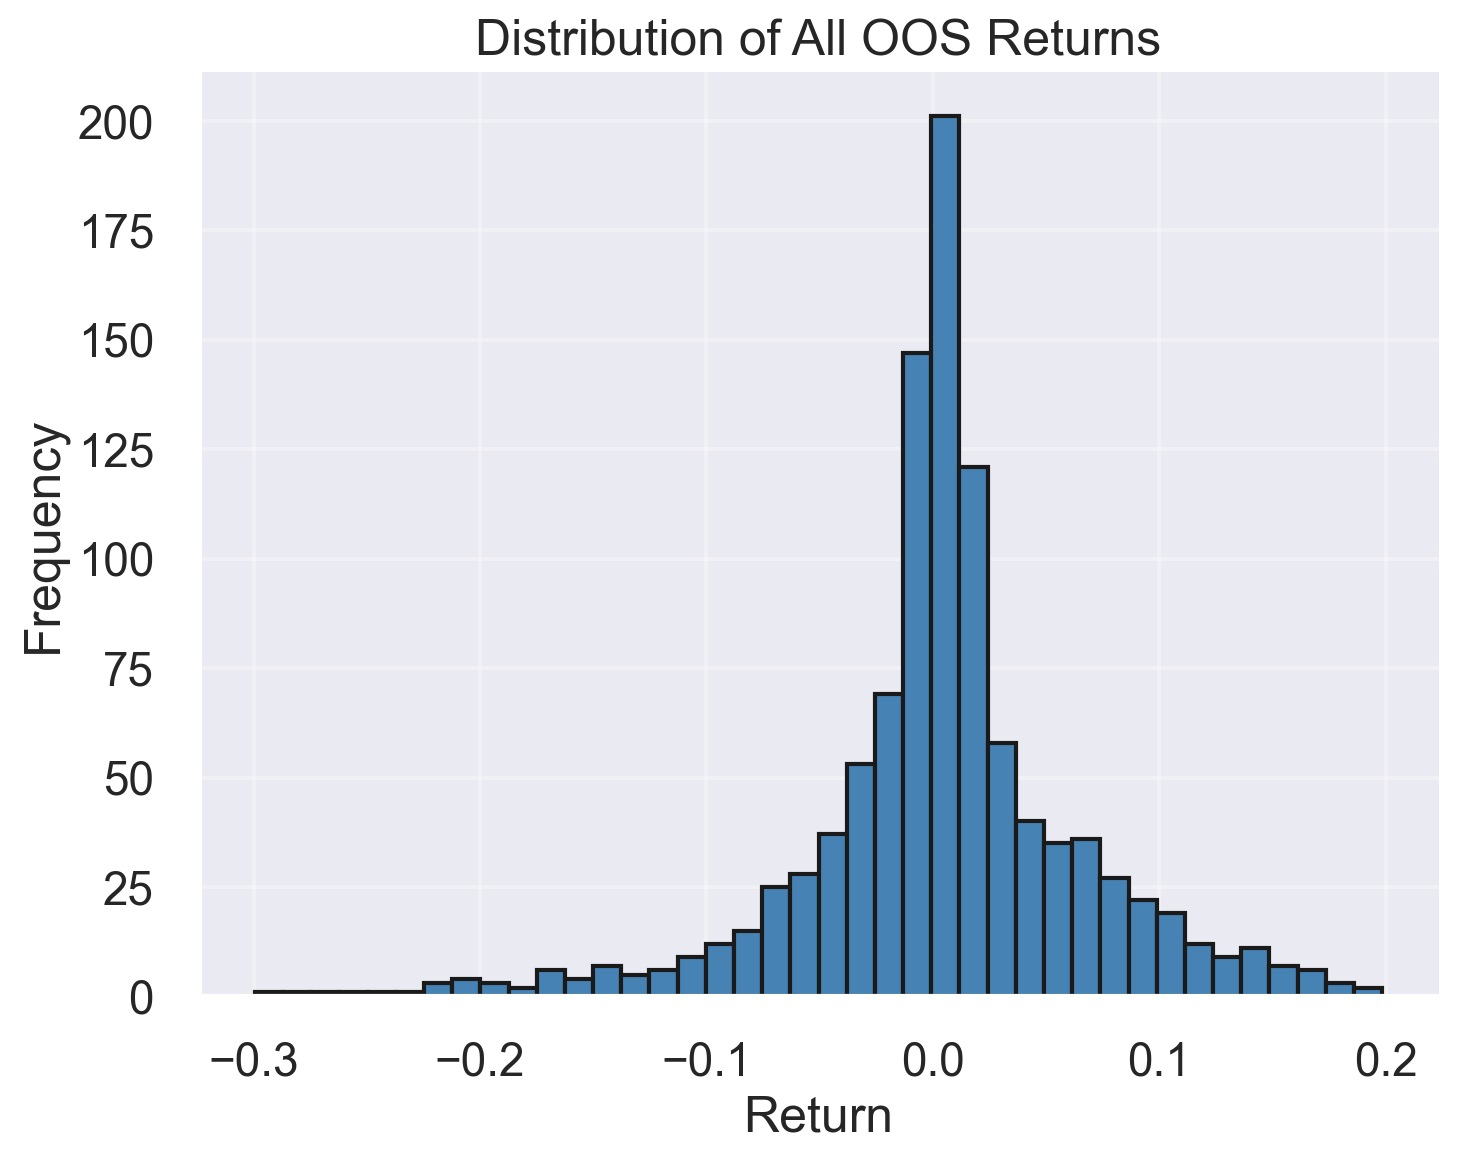

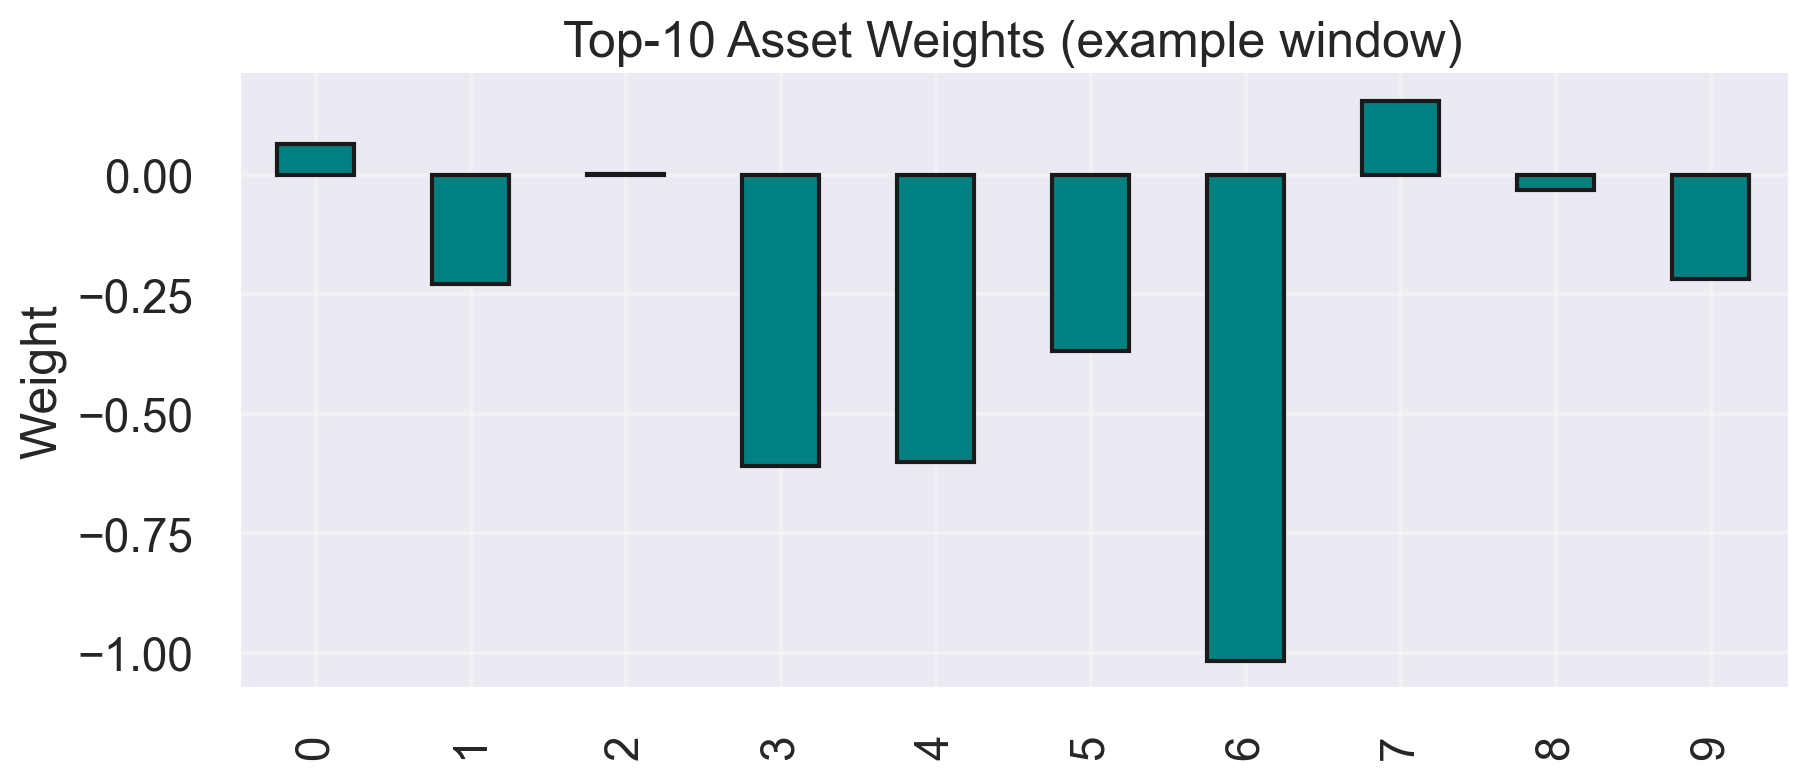

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8")
sns.set_context("talk")
DATA_PATH   = Path("results.csv")    
Q_PATH      = Path("Q.csv")          
B_PATH      = Path("b.csv")           
WEIGHTS_PATH= Path("weights.csv")    
df = pd.read_csv(DATA_PATH)           
print("Data shape:", df.shape)
display(df.head())
display(df.describe())


targets_to_plot = [0.03, 0.05, 0.08]   
fig, ax = plt.subplots(figsize=(12, 6))
for t in targets_to_plot:
    tmp = df[df["target"] == t]
    ax.plot(tmp["window"], tmp["Return"], marker="o", label=f"target {t:.2%}")
ax.set_xlabel("Rolling Window")
ax.set_ylabel("OOS Return")
ax.set_title("Rolling OOS Return by Target")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
df["Return"].hist(bins=40, ax=ax, color="steelblue", edgecolor="k")
ax.set_title("Distribution of All OOS Returns")
ax.set_xlabel("Return"); ax.set_ylabel("Frequency")
plt.show()


if WEIGHTS_PATH.exists():
    weights = pd.read_csv(WEIGHTS_PATH, header=None).iloc[:83, 0]  # only asset weights
    topN = 10
    weights.head(topN).plot(kind="bar", figsize=(10,4), color="teal", edgecolor="k")
    plt.ylabel("Weight"); plt.title("Top-10 Asset Weights (example window)")
    plt.show()



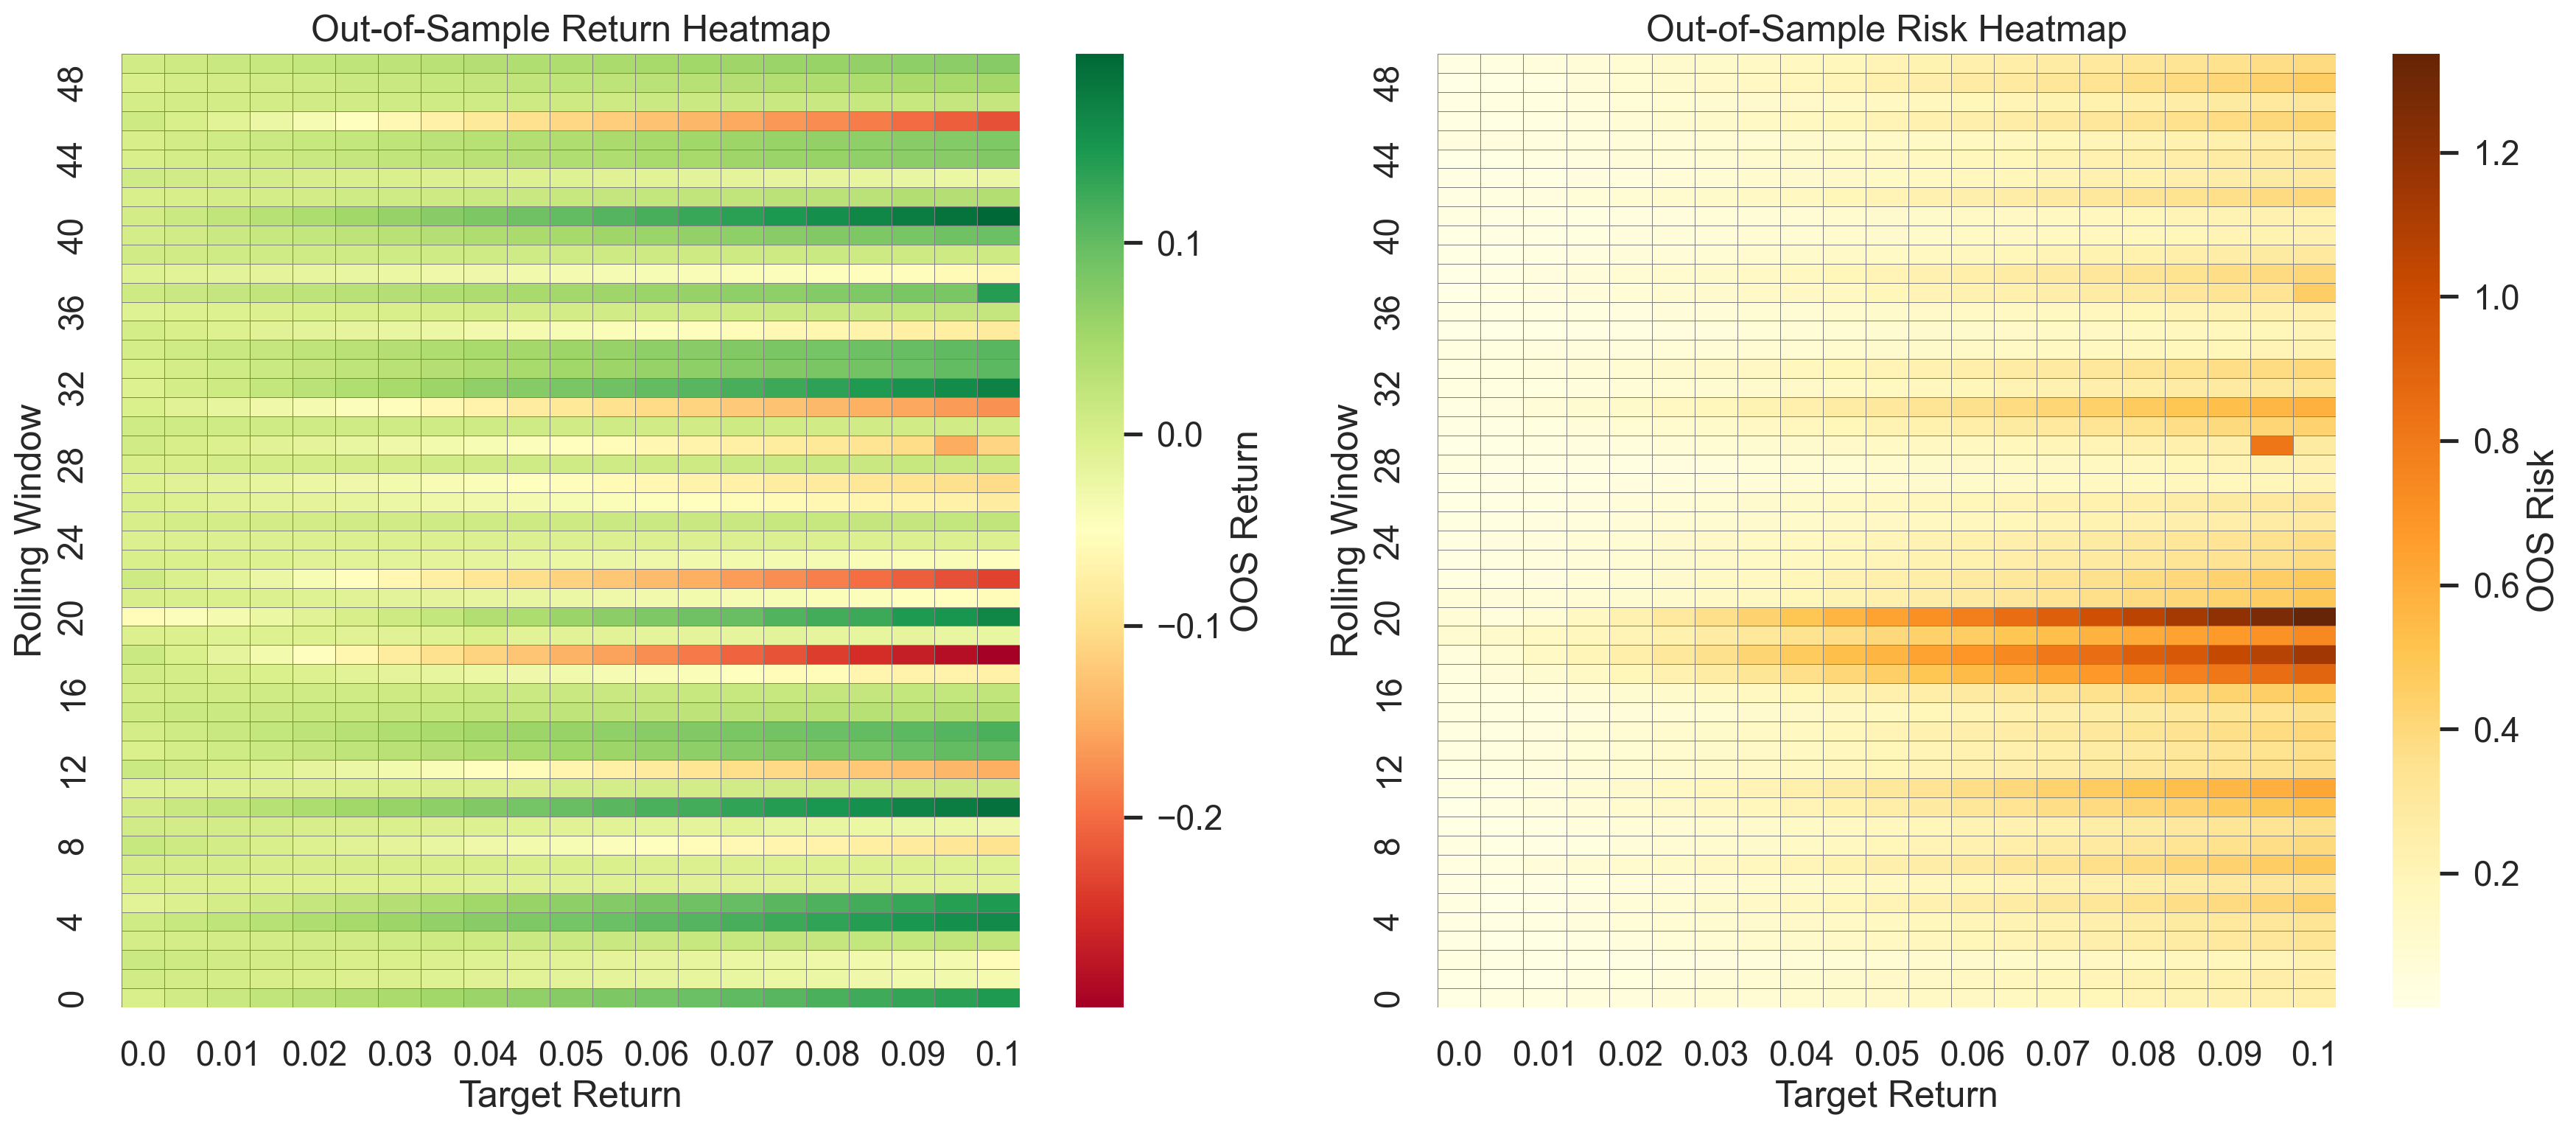

In [47]:
pivot_ret = df.pivot(index="window", columns="target", values="Return")
pivot_risk = df.pivot(index="window", columns="target", values="Risk")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(pivot_ret.sort_index(ascending=True), 
            cmap="RdYlGn", 
            ax=axes[0], 
            cbar_kws={"label": "OOS Return"}, 
            xticklabels=2, yticklabels=4,
            square=False,
            linewidths=0.3, linecolor='gray')
axes[0].set_title("Out-of-Sample Return Heatmap")
axes[0].set_xlabel("Target Return")
axes[0].set_ylabel("Rolling Window")
axes[0].invert_yaxis()  # Lower window at bottom

sns.heatmap(pivot_risk.sort_index(ascending=True), 
            cmap="YlOrBr", 
            ax=axes[1], 
            cbar_kws={"label": "OOS Risk"}, 
            xticklabels=2, yticklabels=4,
            square=False,
            linewidths=0.3, linecolor='gray')
axes[1].set_title("Out-of-Sample Risk Heatmap")
axes[1].set_xlabel("Target Return")
axes[1].set_ylabel("Rolling Window")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


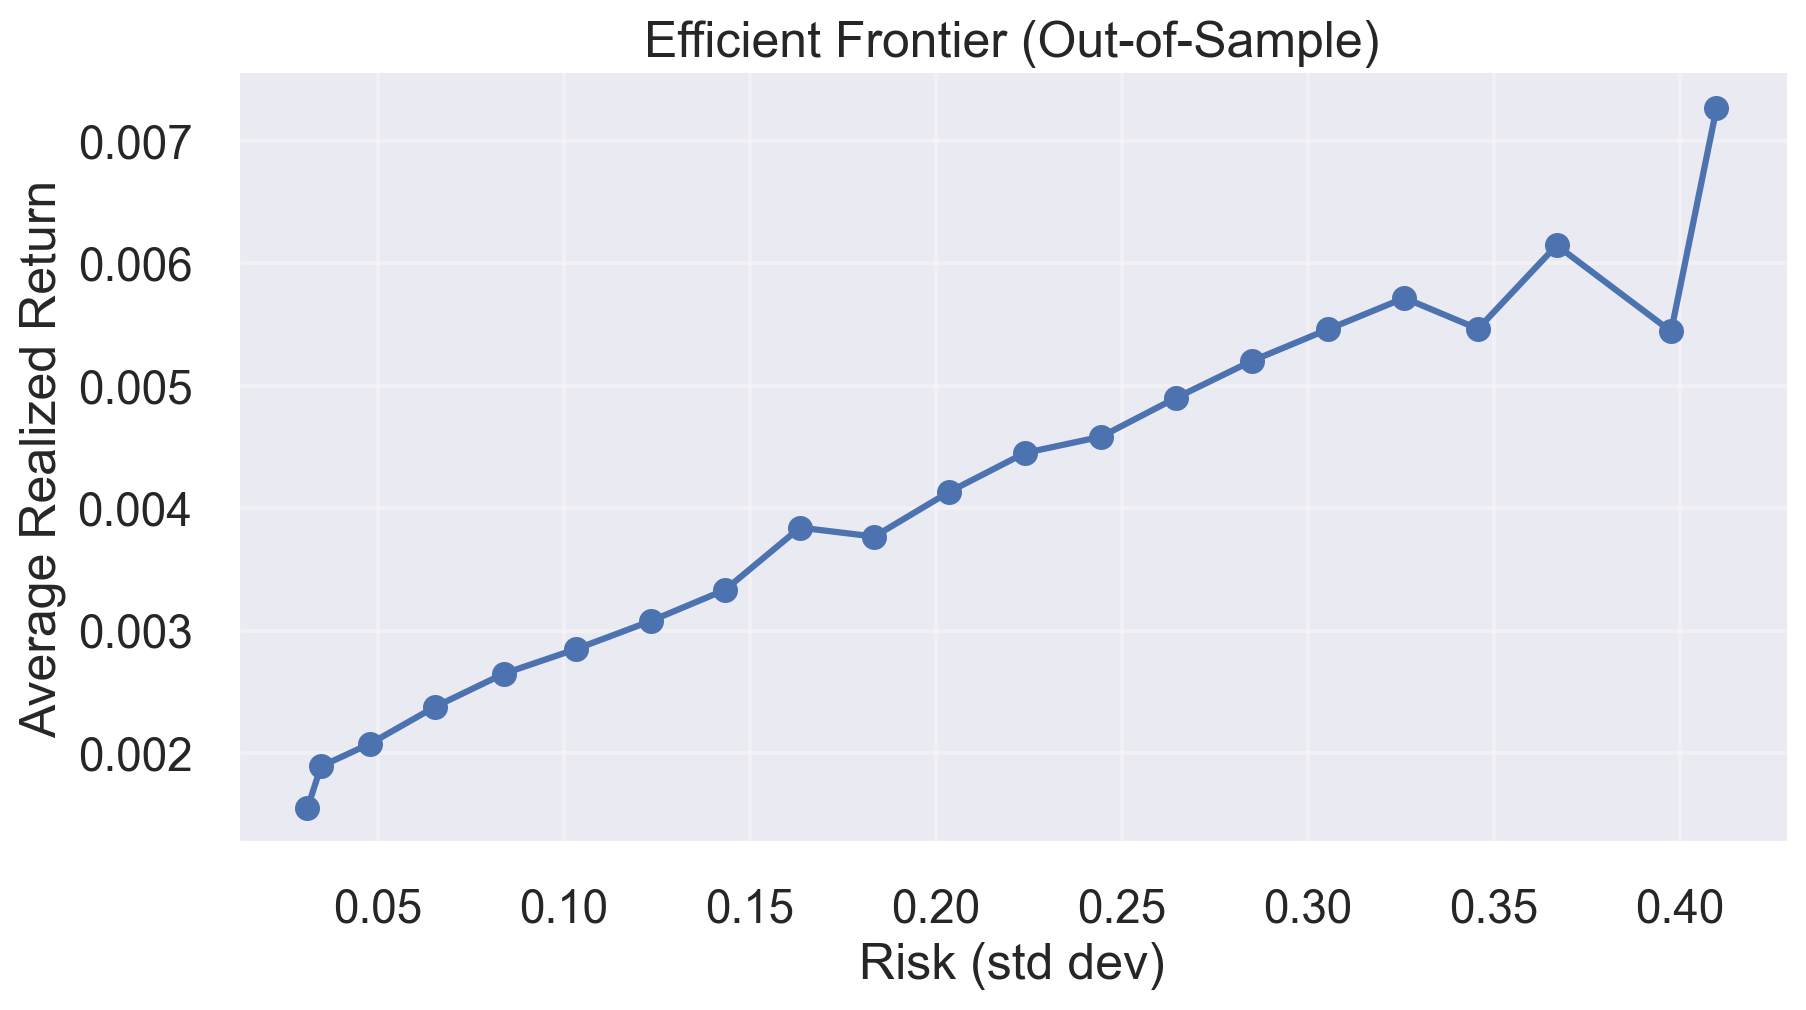

In [48]:
pivot_return = df.pivot(index='window', columns='target', values='Return')
pivot_risk   = df.pivot(index='window', columns='target', values='Risk')
avg_returns = df.groupby('target')['Return'].mean()
avg_risks = df.groupby('target')['Risk'].mean()

plt.figure(figsize=(10, 5))
plt.plot(avg_risks, avg_returns, marker='o')
plt.xlabel('Risk (std dev)')
plt.ylabel('Average Realized Return')
plt.title('Efficient Frontier (Out-of-Sample)')
plt.grid(True)
plt.show()


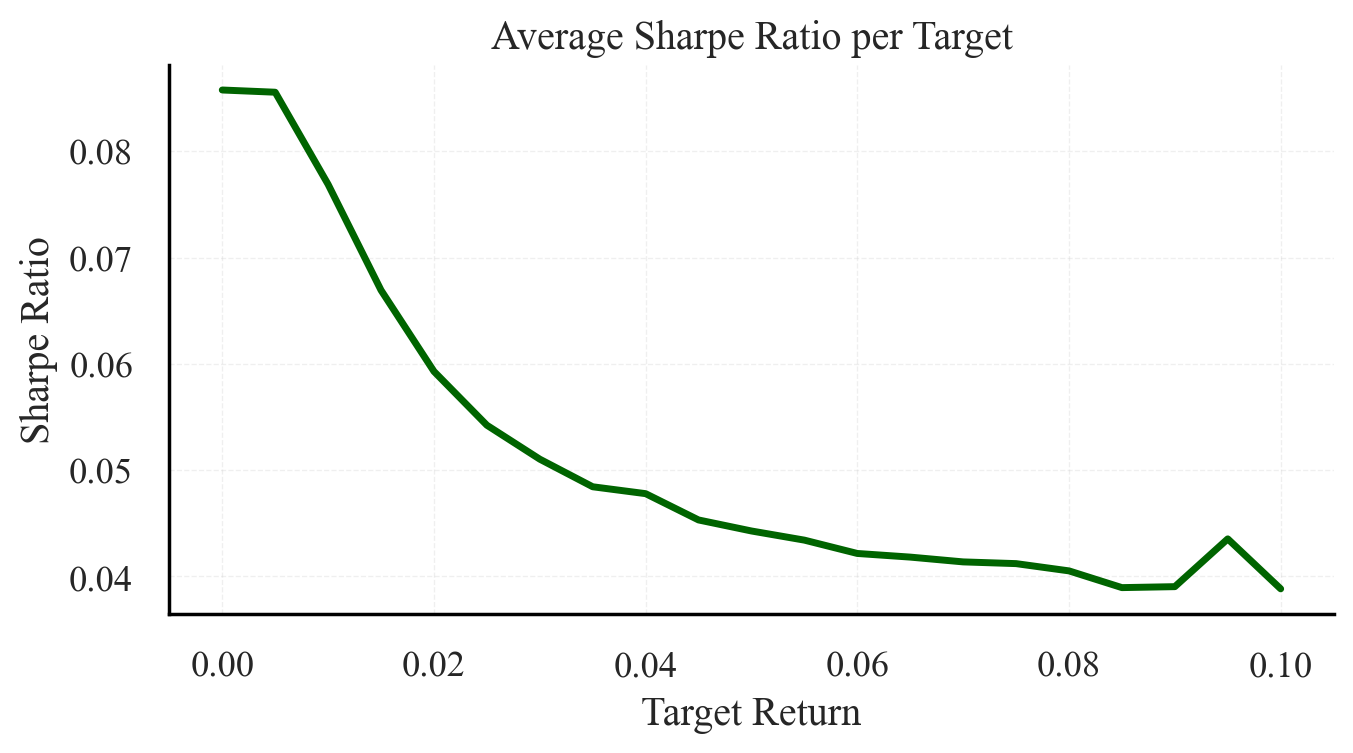

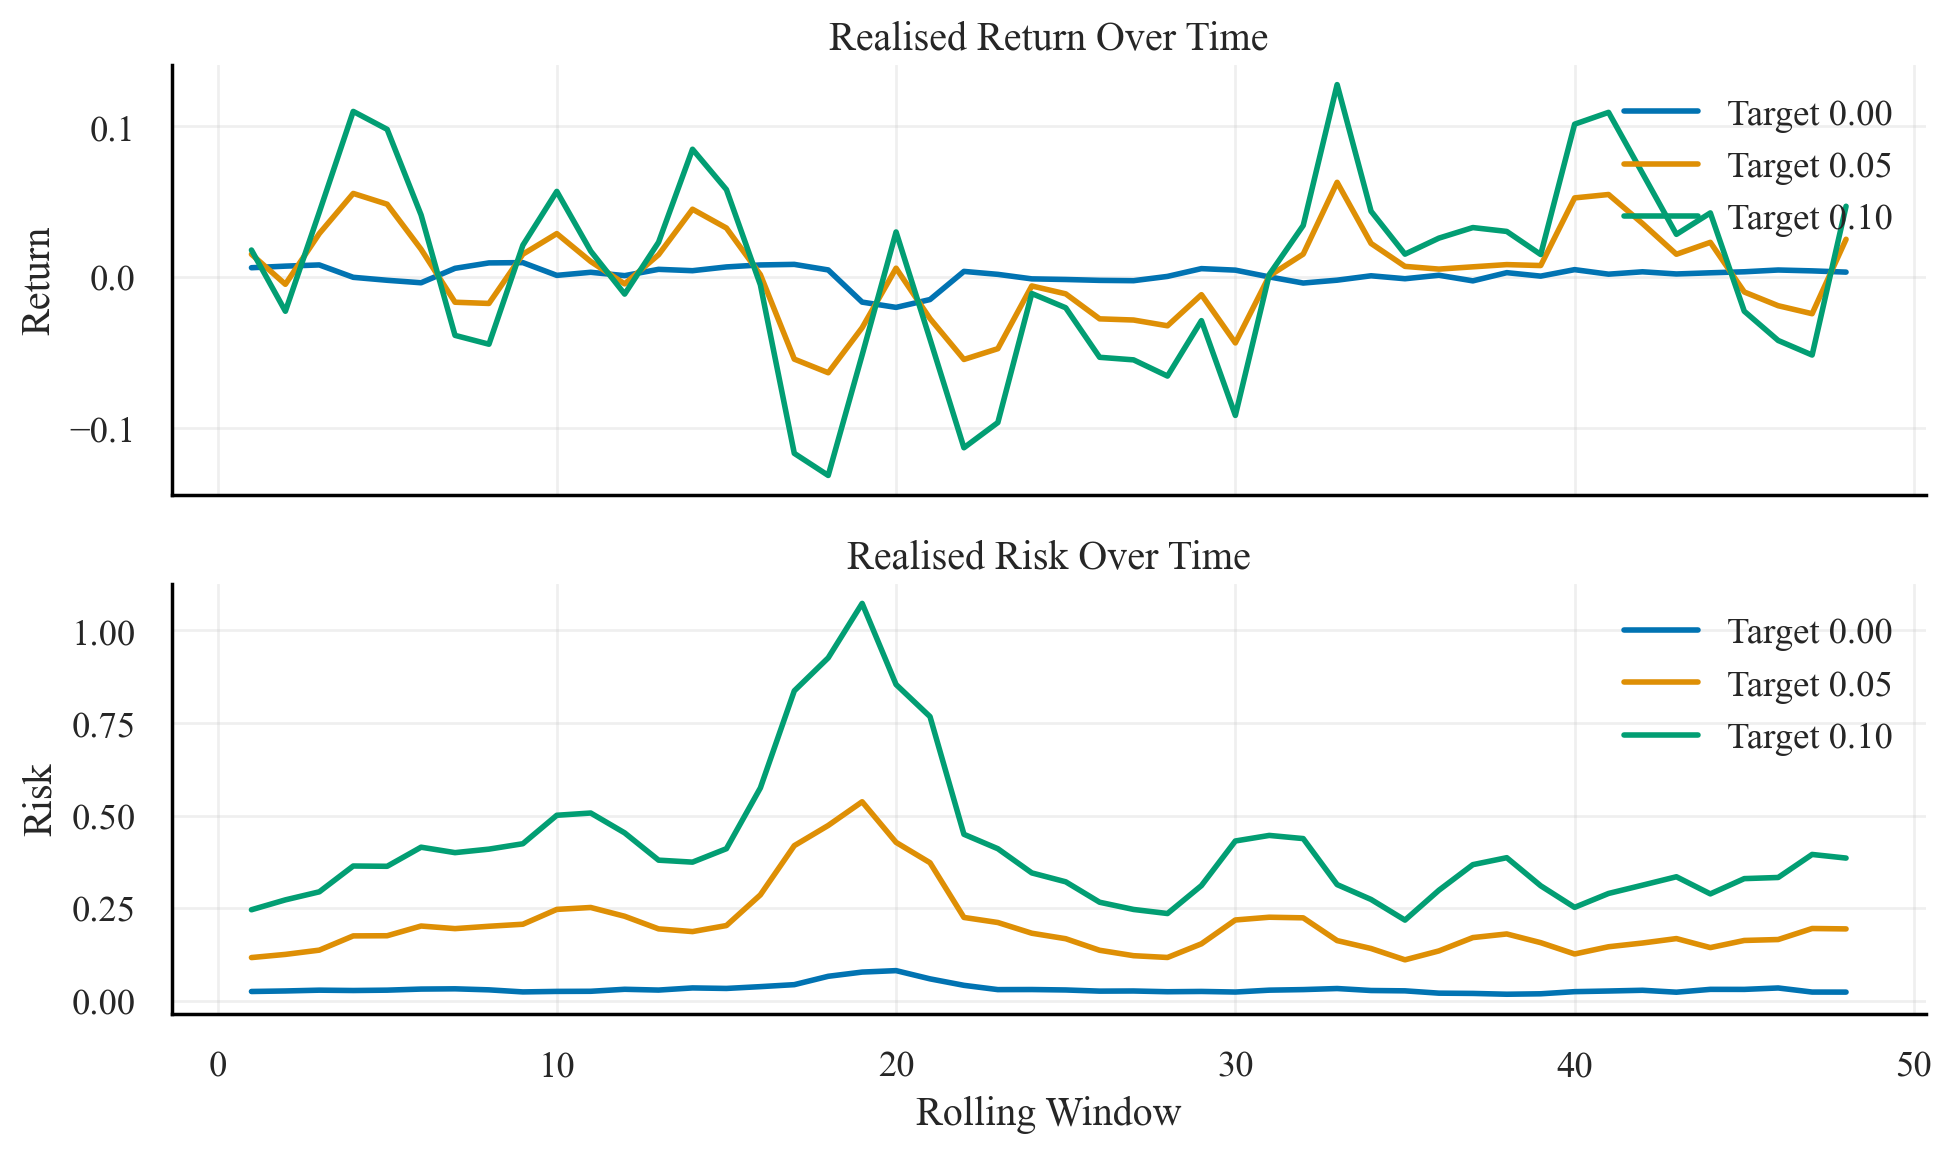

In [49]:
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.edgecolor": "black"
})

df["target"] = df["target"].round(3)
df["sharpe"] = df["Return"] / df["Risk"].replace(0, np.nan)

frontier = df.groupby("target")[["Return", "Risk"]].mean().reset_index()
sharpe_avg = df.groupby("target")["sharpe"].mean().reset_index()
pivot_ret = df.pivot(index="window", columns="target", values="Return").iloc[::2]
pivot_risk = df.pivot(index="window", columns="target", values="Risk").iloc[::2]
sample_targets = [0.00, 0.05, 0.10]


plt.figure(figsize=(7, 4))
sns.lineplot(data=sharpe_avg, x="target", y="sharpe", linewidth=2.5, color='darkgreen')
plt.title("Average Sharpe Ratio per Target")
plt.xlabel("Target Return")
plt.ylabel("Sharpe Ratio")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
palette = sns.color_palette("colorblind", len(sample_targets))

for i, tgt in enumerate(sample_targets):
    sub = df[df["target"] == tgt]
    axes[0].plot(sub["window"], sub["Return"].rolling(3, center=True).mean(),
                 label=f"Target {tgt:.2f}", linewidth=2, color=palette[i])
    axes[1].plot(sub["window"], sub["Risk"].rolling(3, center=True).mean(),
                 label=f"Target {tgt:.2f}", linewidth=2, color=palette[i])

axes[0].set_title("Realised Return Over Time")
axes[0].set_ylabel("Return")
axes[0].legend(loc="upper right")

axes[1].set_title("Realised Risk Over Time")
axes[1].set_ylabel("Risk")
axes[1].set_xlabel("Rolling Window")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()




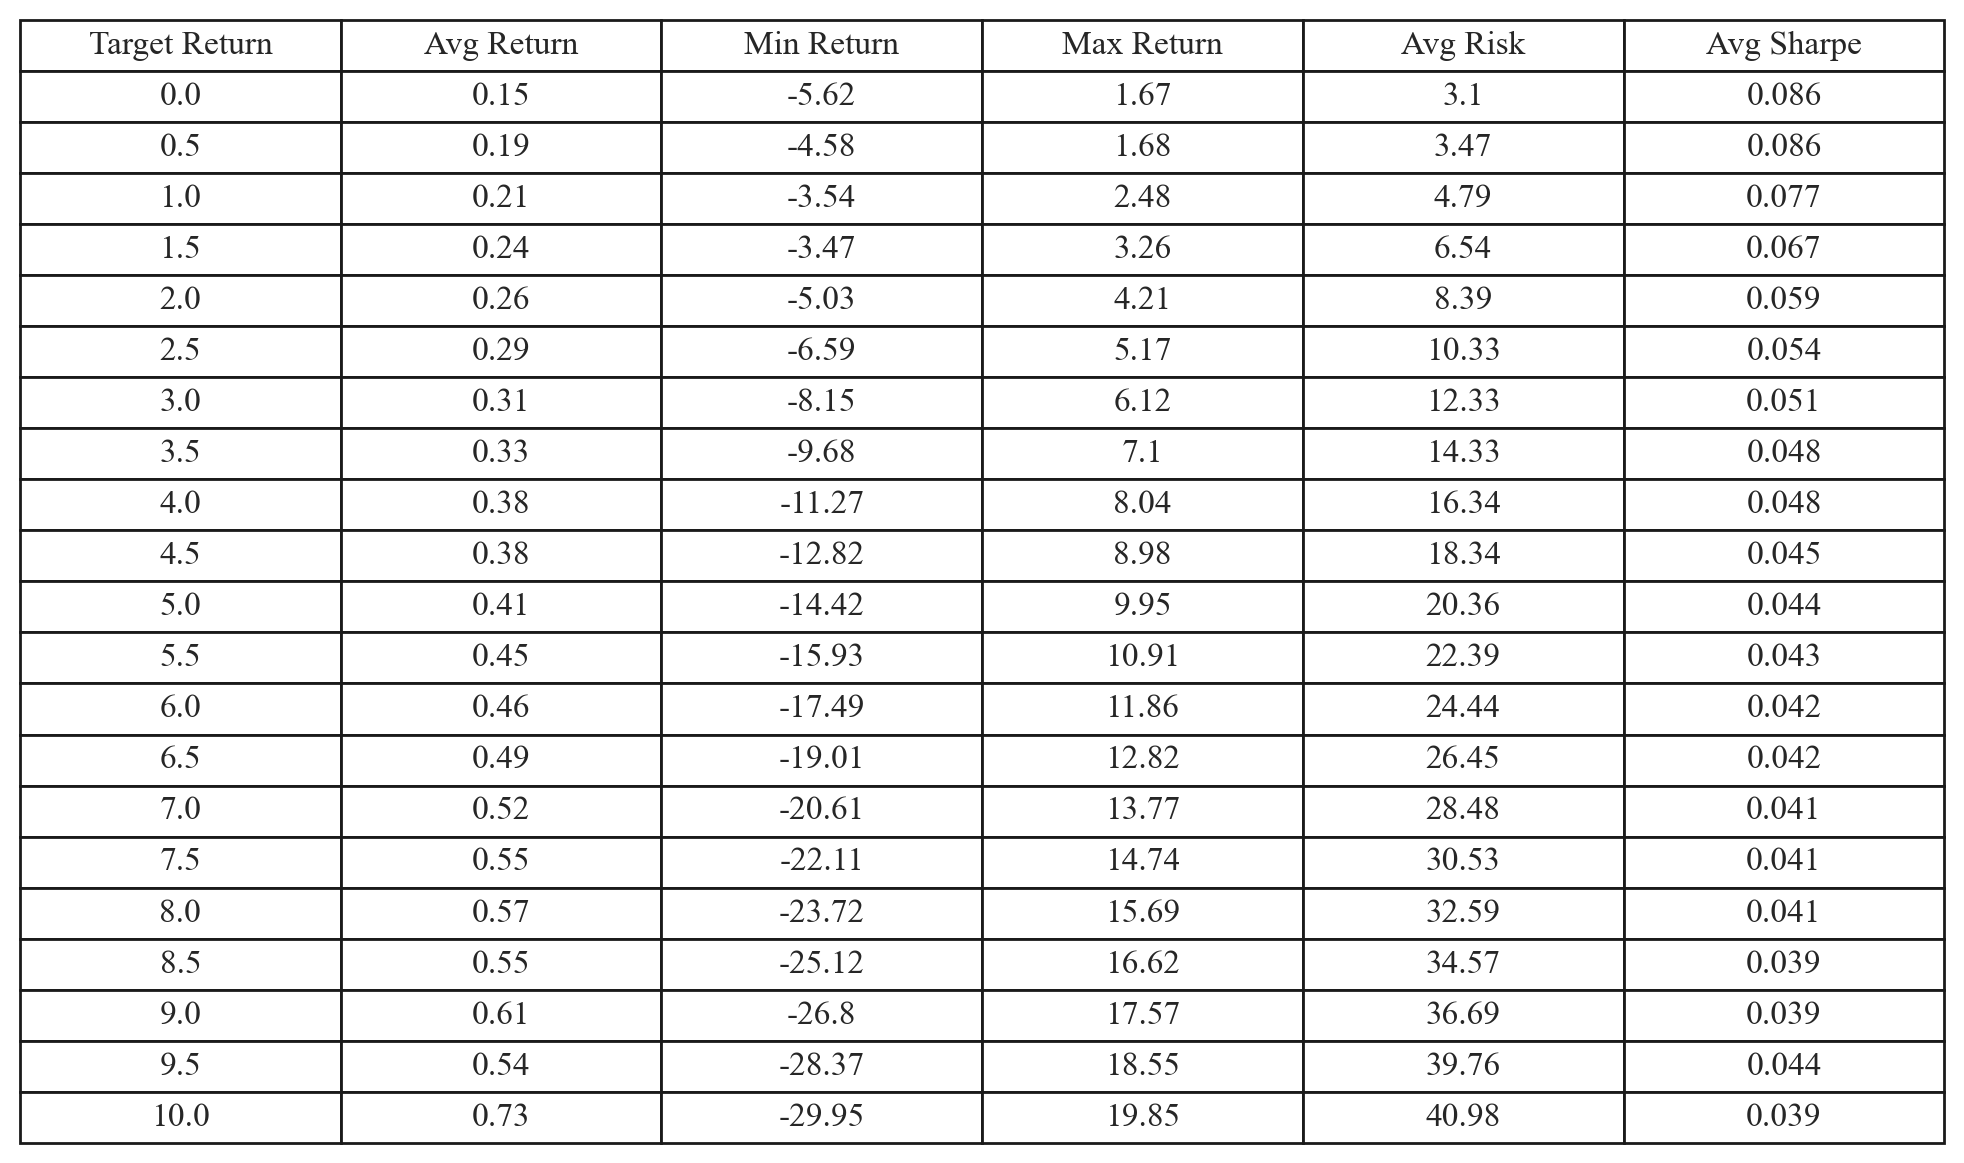

In [50]:
summary = df.groupby("target").agg({
    "Return": ["mean", "min", "max"],
    "Risk": "mean",
    "sharpe": "mean"
}).reset_index()

summary.columns = ["Target Return",
                   "Avg Return", "Min Return", "Max Return",
                   "Avg Risk", "Avg Sharpe"]

summary[["Target Return", "Avg Return", "Min Return", "Max Return", "Avg Risk"]] *= 100

summary = summary.round({
    "Target Return": 2,
    "Avg Return": 2,
    "Min Return": 2,
    "Max Return": 2,
    "Avg Risk": 2,
    "Avg Sharpe": 3
})

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
table = ax.table(cellText=summary.values,
                 colLabels=summary.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
plt.tight_layout()
plt.savefig("summary_table.png", dpi=300, bbox_inches='tight')
plt.show()


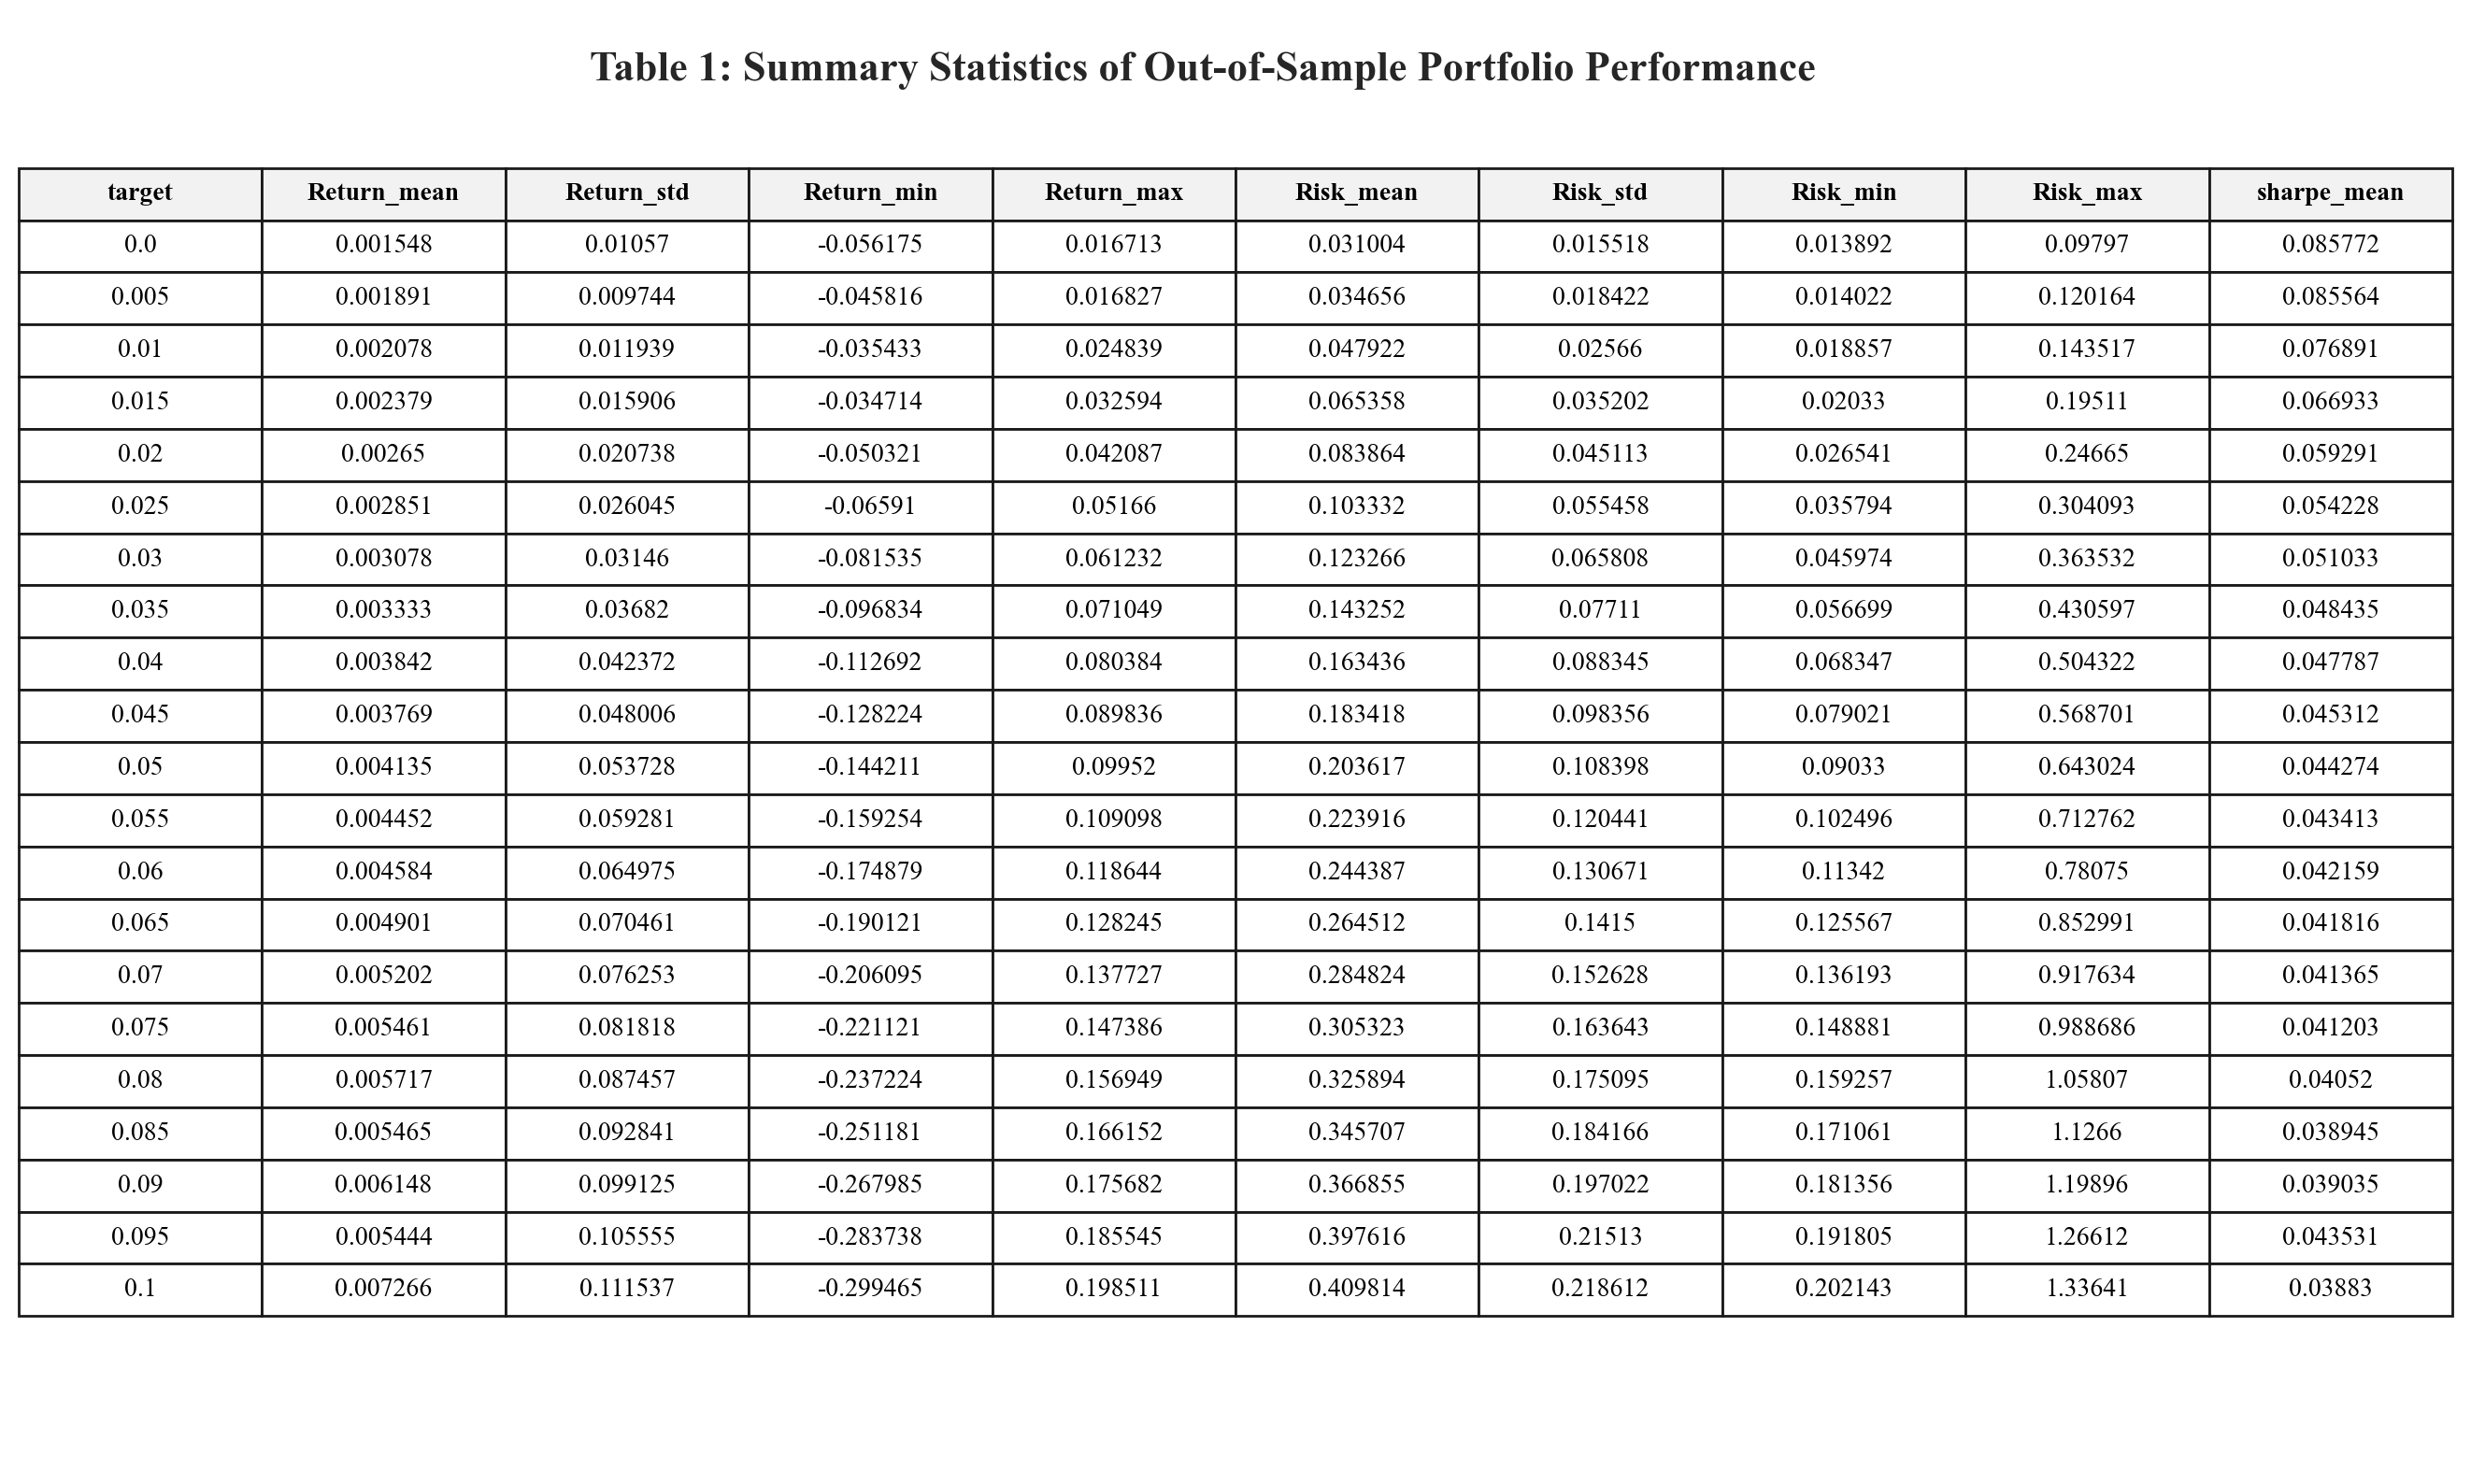

In [51]:
summary = df.groupby("target").agg({
    "Return": ['mean', 'std', 'min', 'max'],
    "Risk": ['mean', 'std', 'min', 'max'],
    "sharpe": ['mean']
}).round(6)

summary.columns = [f'{metric}_{stat}' for metric, stat in summary.columns]
summary = summary.reset_index()


fig, ax = plt.subplots(figsize=(14, 9))  # Adjust height if table cuts off
ax.axis('off')
fig.patch.set_facecolor('white')
fig.suptitle("Table 1: Summary Statistics of Out-of-Sample Portfolio Performance",
             fontsize=16, fontweight='bold', y=0.9)

table = plt.table(cellText=summary.values,
                  colLabels=summary.columns,
                  cellLoc='center',
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)


for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#f2f2f2")
        cell.set_text_props(weight='bold', color='black')
    else:
        cell.set_facecolor("white")
        cell.set_text_props(color='black')

plt.subplots_adjust(top=0.92, bottom=0.06)
plt.savefig("summary_table_final.png", dpi=300, bbox_inches="tight")
plt.show()
